In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

**Defining the encoder-decoder model**

In [3]:
class Encoder(nn.Module):
    def __init__(self, bottleneck_dim=64):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.ReLU(True),
            nn.Conv2d(64, bottleneck_dim, kernel_size=7),  # No padding, output: (bottleneck_dim, 1, 1)
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

class Decoder(nn.Module):
    def __init__(self, bottleneck_dim=64):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(bottleneck_dim, 64, kernel_size=7),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dim=64):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(bottleneck_dim)
        self.decoder = Decoder(bottleneck_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [22]:
enc = Encoder()
y = enc(torch.rand((8,1,28,28)))
dec = Decoder()
z = dec(y)
y.shape,z.shape

(torch.Size([8, 64, 1, 1]), torch.Size([8, 1, 28, 28]))

torch.Size([8, 1, 28, 28])

**Dataset and Dataloader**

In [6]:
train_dataset = datasets.MNIST(root='/ssd_scratch/cvit/sou/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='/ssd_scratch/cvit/sou/', train=False, download=True, transform=transforms.ToTensor())


In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Helper Functions**

In [8]:
def add_gaussian_noise(images, sigma):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0, 1)

def calculate_ssim(original_images, reconstructed_images):
    ssim_scores = []
    for original, reconstructed in zip(original_images, reconstructed_images):
        original = original.squeeze().detach().cpu().numpy()
        reconstructed = reconstructed.squeeze().detach().cpu().numpy()
        score = ssim(original, reconstructed, data_range=1)
        ssim_scores.append(score)
    return sum(ssim_scores) / len(ssim_scores)


def plot_images(original, reconstructed, epoch):
    """
    Plots original and reconstructed images side by side.
    Args:
    - original: tensor, original images.
    - reconstructed: tensor, reconstructed images generated by the model.
    - epoch: int, the current training epoch.
    - examples: int, number of examples to plot.
    """
    original = original.cpu().detach().numpy()
    reconstructed = reconstructed.cpu().detach().numpy()
    #print(reconstructed.shape)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))
    # Original Image
    ax = axes[0]
    ax.imshow(original, cmap='gray')
    ax.set_title(f"Original - Epoch {epoch}")
    ax.axis('off')

    # Reconstructed Image
    ax = axes[1]
    ax.imshow(reconstructed, cmap='gray')
    ax.set_title(f"Reconstructed - Epoch {epoch}")
    ax.axis('off')

    plt.tight_layout()
    plt.show()



In [14]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=50,sigma = 0.1):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            noisy_images = add_gaussian_noise(images, sigma=sigma)
            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        plot_images(noisy_images[0].permute(1,2,0), outputs[0].permute(1,2,0), epoch+1)


def test_model(model, test_loader, sigma):
    model.eval()
    ssim_scores = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            noisy_images = add_gaussian_noise(images, sigma=sigma)
            outputs = model(noisy_images)
            ssim_score = calculate_ssim(images, outputs)
            ssim_scores.append(ssim_score)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)
    return avg_ssim


### Various Values of Sigma

Epoch [1/10], Loss: 0.0414


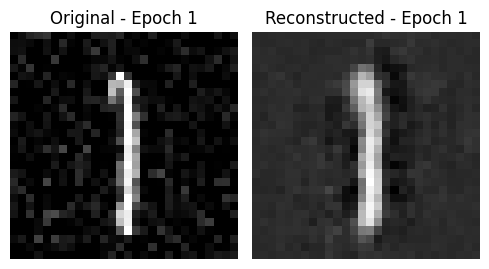

Epoch [2/10], Loss: 0.0116


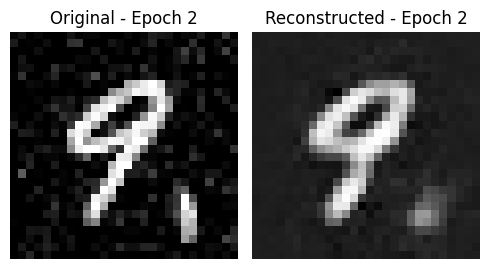

Epoch [3/10], Loss: 0.0092


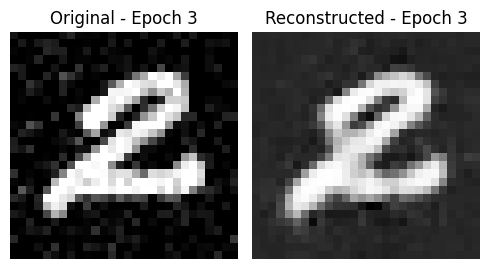

Epoch [4/10], Loss: 0.0082


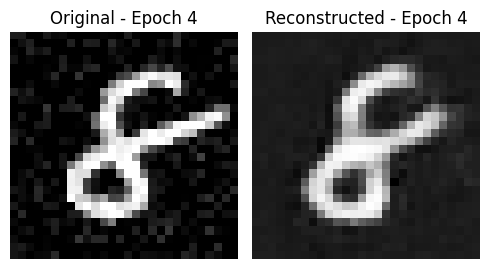

Epoch [5/10], Loss: 0.0076


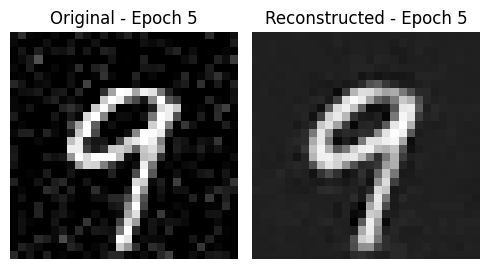

Epoch [6/10], Loss: 0.0072


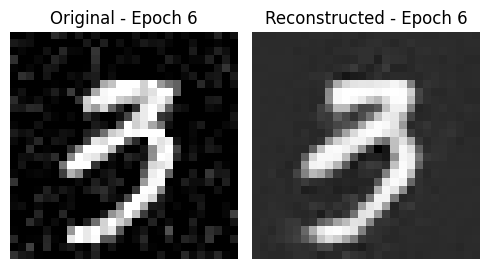

Epoch [7/10], Loss: 0.0069


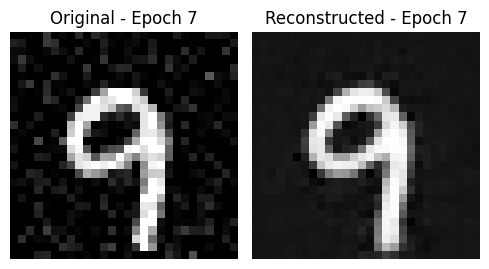

Epoch [8/10], Loss: 0.0067


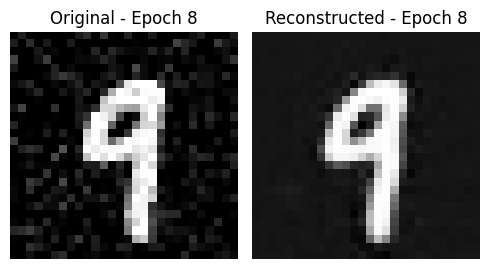

Epoch [9/10], Loss: 0.0065


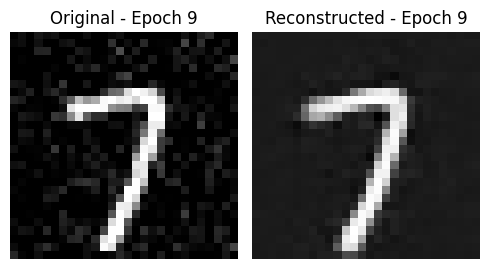

Epoch [10/10], Loss: 0.0063


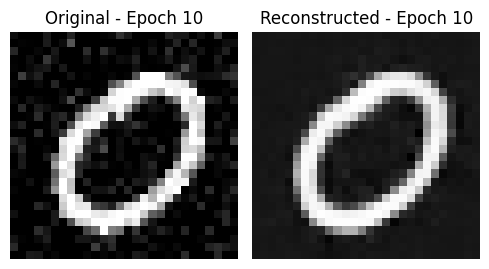

In [10]:
# Training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epochs = 10

# Initialize model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs,sigma = 0.1)

Epoch [1/10], Loss: 0.0260


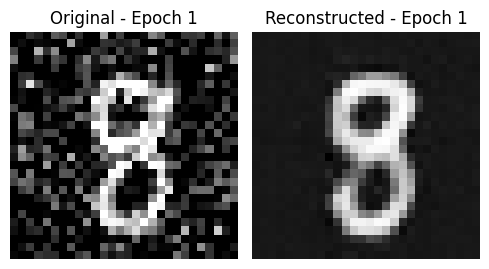

Epoch [2/10], Loss: 0.0107


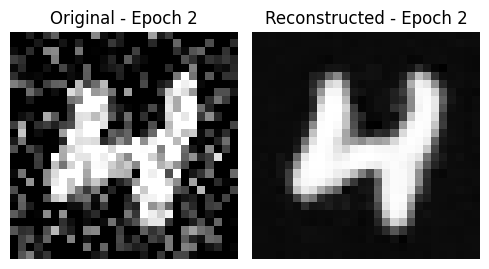

Epoch [3/10], Loss: 0.0093


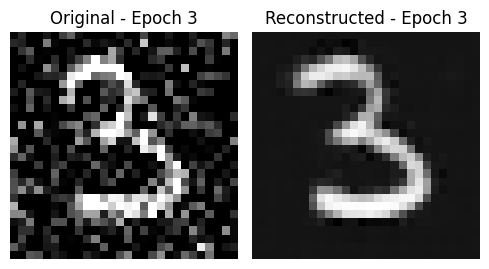

Epoch [4/10], Loss: 0.0086


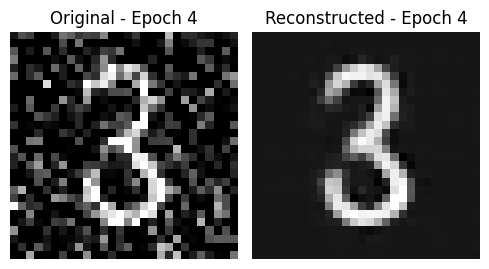

Epoch [5/10], Loss: 0.0082


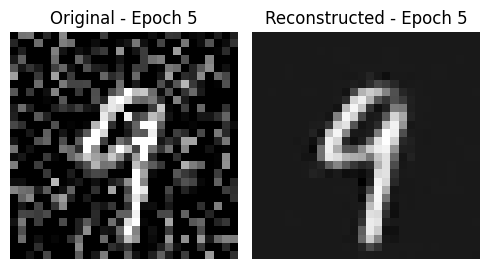

Epoch [6/10], Loss: 0.0079


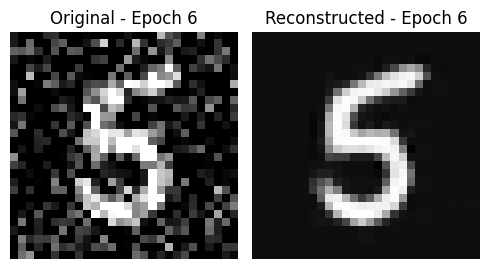

Epoch [7/10], Loss: 0.0077


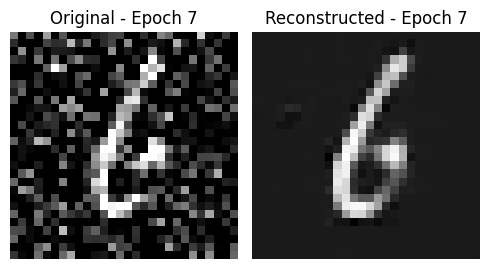

Epoch [8/10], Loss: 0.0076


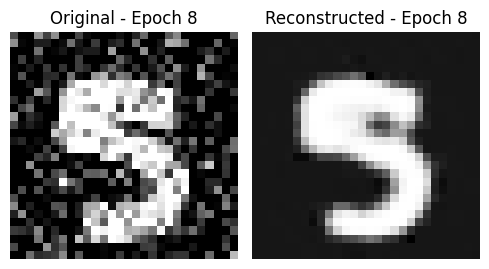

Epoch [9/10], Loss: 0.0074


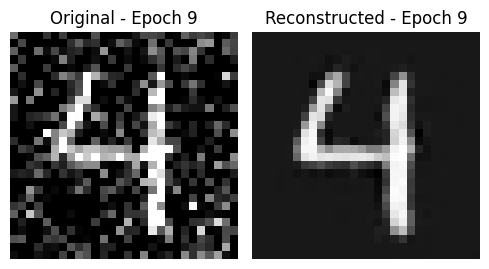

Epoch [10/10], Loss: 0.0073


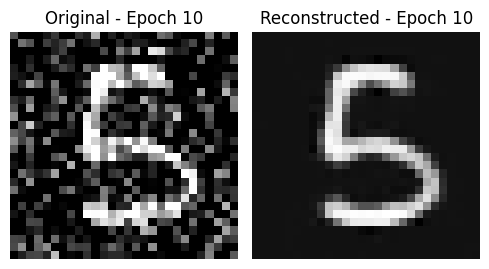

In [12]:
# Training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epochs = 10

# Initialize model, loss function, and optimizer
model_sigma_03 = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer_sigma_03 = optim.Adam(model_sigma_03.parameters(), lr=learning_rate)

# Train the model
train_model(model_sigma_03, train_loader, criterion, optimizer_sigma_03, num_epochs=num_epochs,sigma = 0.3)

Epoch [1/10], Loss: 0.0282


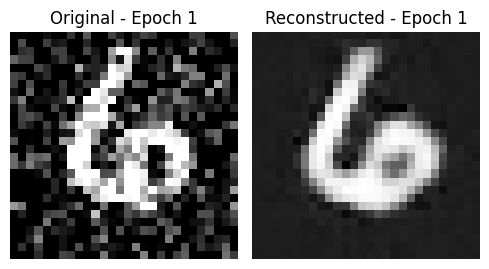

Epoch [2/10], Loss: 0.0114


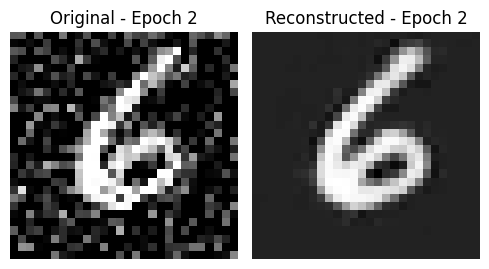

Epoch [3/10], Loss: 0.0098


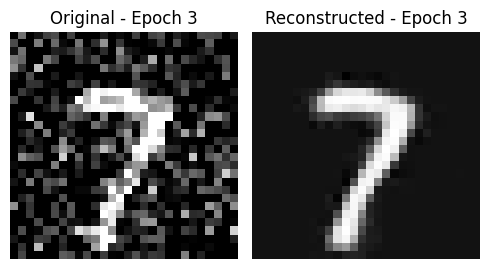

Epoch [4/10], Loss: 0.0091


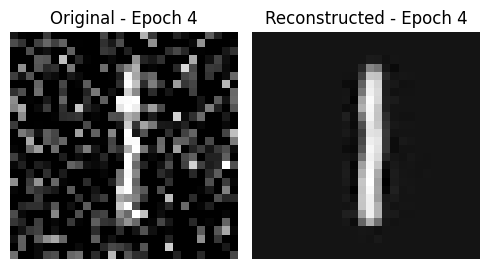

Epoch [5/10], Loss: 0.0086


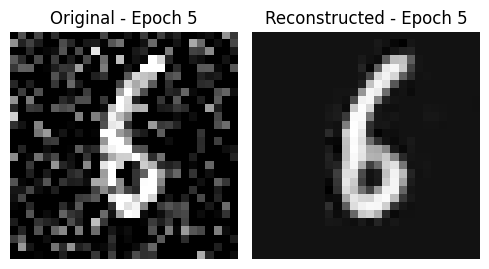

Epoch [6/10], Loss: 0.0083


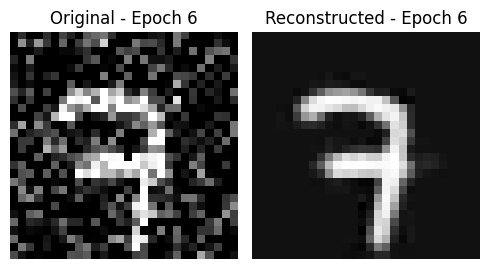

Epoch [7/10], Loss: 0.0081


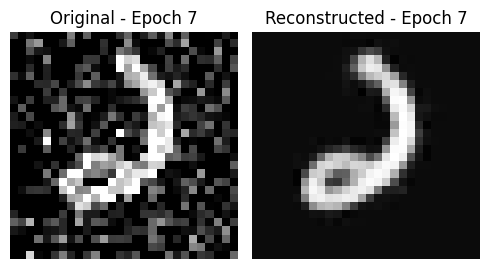

Epoch [8/10], Loss: 0.0079


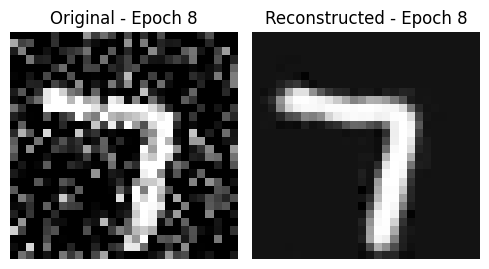

Epoch [9/10], Loss: 0.0078


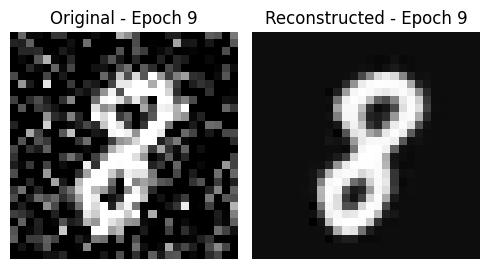

Epoch [10/10], Loss: 0.0077


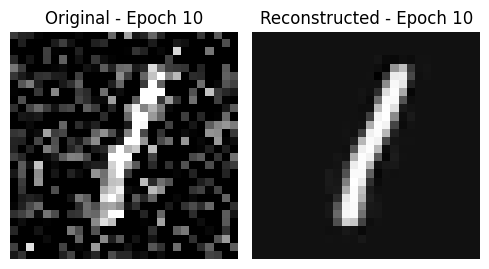

In [13]:
# Training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epochs = 10

# Initialize model, loss function, and optimizer
model_sigma_05 = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer_sigma_05 = optim.Adam(model_sigma_05.parameters(), lr=learning_rate)

# Train the model
train_model(model_sigma_05, train_loader, criterion, optimizer_sigma_05, num_epochs=num_epochs,sigma = 0.3)

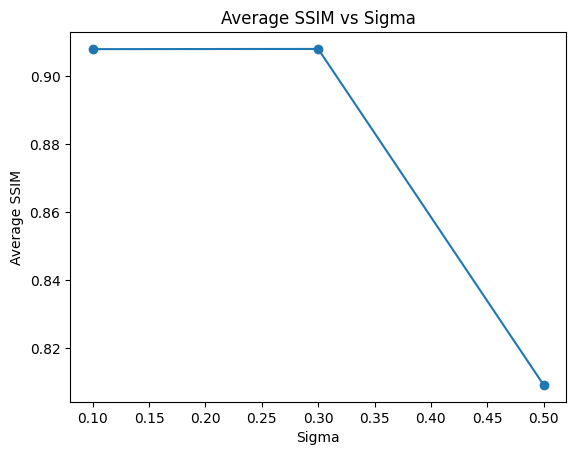

In [16]:
ssim_scores = []
sigmas = [0.1, 0.3, 0.5]
models = [model,model_sigma_03,model_sigma_05]
i=0
for sigma in sigmas:
    avg_ssim = test_model(models[i], test_loader,sigma)
    i+=1
    ssim_scores.append(avg_ssim)

# Plot the results
plt.plot(sigmas, ssim_scores, marker='o')
plt.title('Average SSIM vs Sigma')
plt.xlabel('Sigma')
plt.ylabel('Average SSIM')
plt.show()

### Various Bottleneck Dimensions for Sigma=0.5

Epoch [1/10], Loss: 0.0314


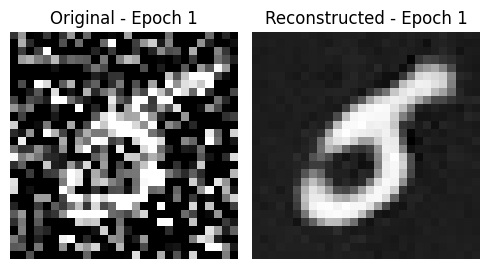

Epoch [2/10], Loss: 0.0150


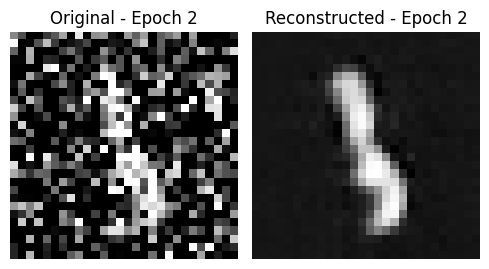

Epoch [3/10], Loss: 0.0133


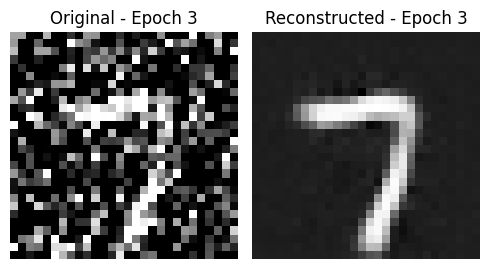

Epoch [4/10], Loss: 0.0126


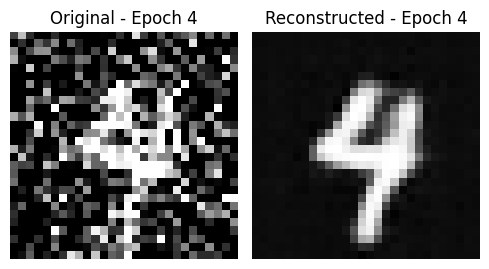

Epoch [5/10], Loss: 0.0121


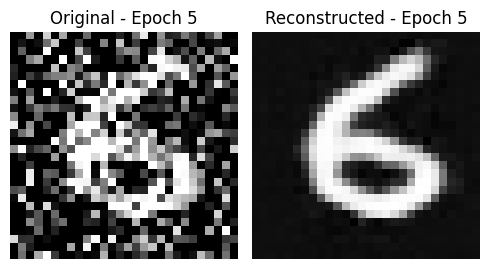

Epoch [6/10], Loss: 0.0118


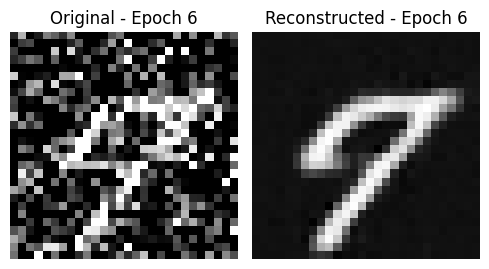

Epoch [7/10], Loss: 0.0116


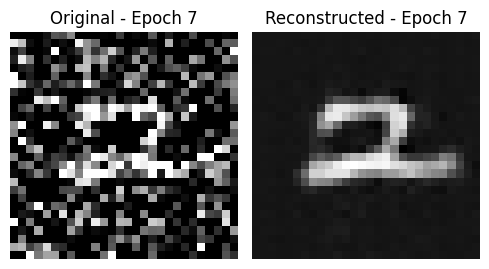

Epoch [8/10], Loss: 0.0114


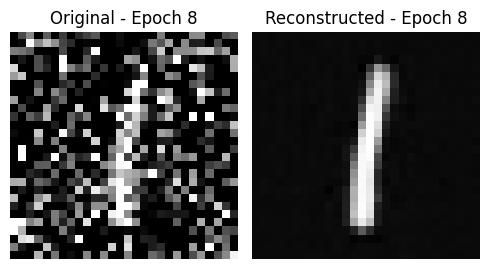

Epoch [9/10], Loss: 0.0113


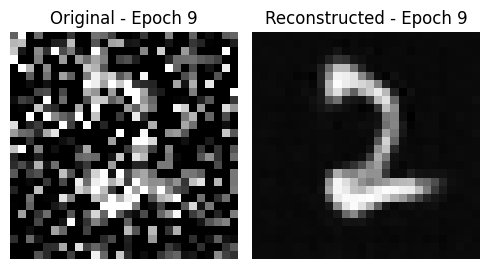

Epoch [10/10], Loss: 0.0112


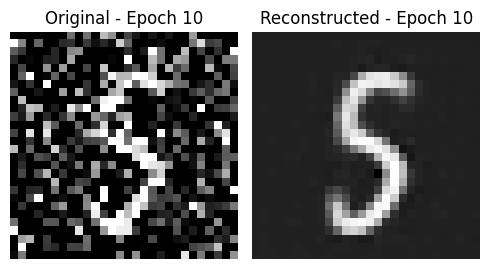

In [18]:
# Training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epochs = 10

# Initialize model, loss function, and optimizer
model_bn_128 = Autoencoder(128).to(device)
criterion = nn.MSELoss()
optimizer_bn_128 = optim.Adam(model_bn_128.parameters(), lr=learning_rate)

# Train the model
train_model(model_bn_128, train_loader, criterion, optimizer_bn_128, num_epochs=num_epochs,sigma = 0.5)

Epoch [1/10], Loss: 0.0387


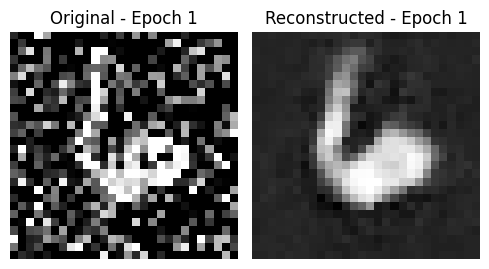

Epoch [2/10], Loss: 0.0156


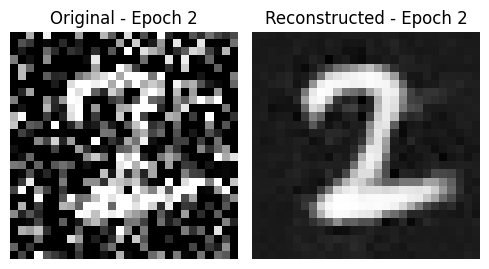

Epoch [3/10], Loss: 0.0134


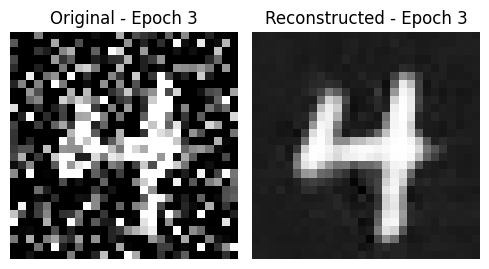

Epoch [4/10], Loss: 0.0124


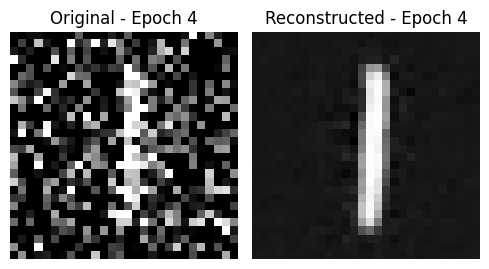

Epoch [5/10], Loss: 0.0119


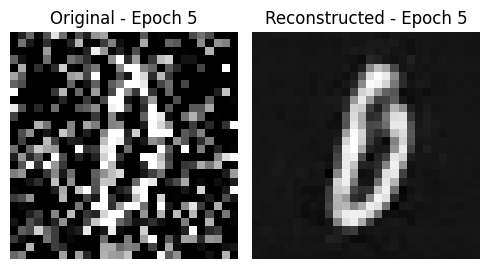

Epoch [6/10], Loss: 0.0115


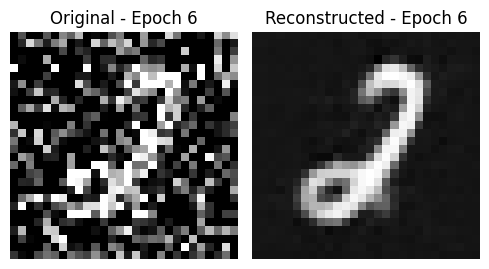

Epoch [7/10], Loss: 0.0112


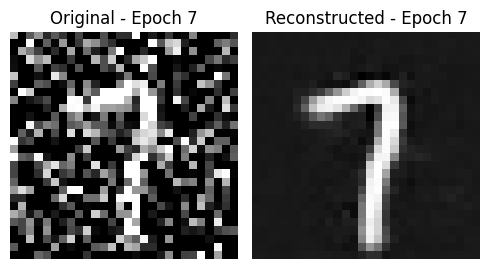

Epoch [8/10], Loss: 0.0110


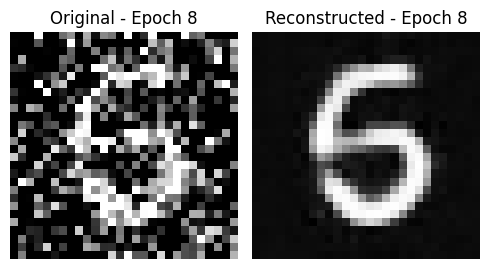

Epoch [9/10], Loss: 0.0109


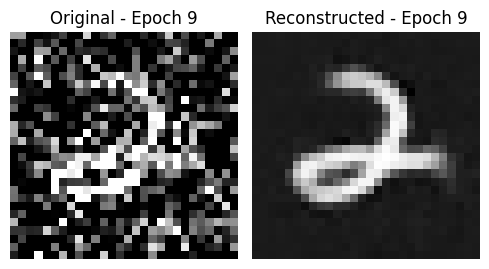

Epoch [10/10], Loss: 0.0107


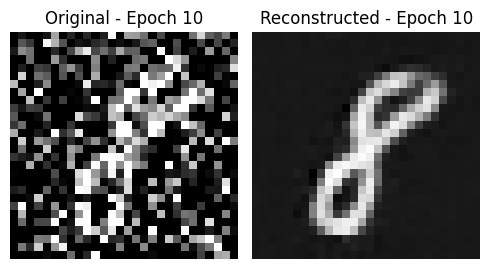

In [20]:
# Training settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epochs = 10

# Initialize model, loss function, and optimizer
model_bn_256 = Autoencoder(256).to(device)
criterion = nn.MSELoss()
optimizer_bn_256 = optim.Adam(model_bn_256.parameters(), lr=learning_rate)

# Train the model
train_model(model_bn_256, train_loader, criterion, optimizer_bn_256, num_epochs=num_epochs,sigma = 0.5)

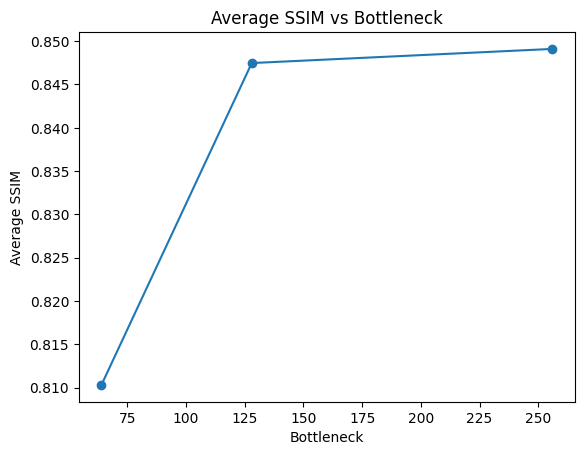

In [21]:
ssim_scores = []
bottleneck = [64, 128, 256]
models = [model_sigma_05,model_bn_128,model_bn_256]
for model in models:
    avg_ssim = test_model(model, test_loader,0.5)
    ssim_scores.append(avg_ssim)

# Plot the results
plt.plot(bottleneck, ssim_scores, marker='o')
plt.title('Average SSIM vs Bottleneck')
plt.xlabel('Bottleneck')
plt.ylabel('Average SSIM')
plt.show()